In [107]:
import os
import random
import h5py
import nova
import numpy as np
from config import dataset_paths, sample_size
%matplotlib inline
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import pandas as pd

def get_curve(x, thres=(0.5, 1.4)):
    sigma = np.std(x[np.intersect1d(np.where(x > thres[0]), np.where(x < thres[1]))])
    mu = np.mean(x[np.intersect1d(np.where(x > thres[0]), np.where(x < thres[1]))])
    return mu, sigma

# build a rectangle in axes coords
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

In [2]:
x_path, y_path, vtx_path = dataset_paths(mode='nue', dataset='flat', vertex=True)

In [3]:
batch_size=8
# filenames = [str(i) + ".h5" for i in range(1300)]
filenames = list(set(n for n in os.listdir(x_path) if n.endswith(".h5")) & set(n for n in os.listdir(y_path) if n.endswith(".h5")))
train_files = filenames[0:4*len(filenames)//5]
valid_files = filenames[4*len(filenames)//5:]
print("Number of training files:\t{}\nNumber of validation files:\t{}".format(len(train_files), len(valid_files)))

# Print number of training examples
train_files, train_count = sample_size(train_files, y_path)
print("Number of training examples:\t{}".format(train_count))
valid_files, valid_count = sample_size(valid_files, y_path)
print("Number of validation examples:\t{}".format(valid_count))

train_gen = nova.vtxgenerator(input_path=x_path,
                           output_path=y_path,
                           batch_size=batch_size,
                           filenames=train_files,
                           sample=False,
                           check_ids=True,
                           random_flip=False)

Number of training files:	316
Number of validation files:	79
Number of training examples:	972701
Number of validation examples:	241242


In [35]:
def plot_event_with_vtx(x, vtx, idx=0):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

    for i, plane in enumerate(x):
        axes[i].set_xlim([0,150])
        axes[i].set_ylim([0,140])

        wire, tick = np.nonzero(plane[idx, :, :, 0])
        energies = plane[idx, wire, tick, 0]

        rgba_colors = np.zeros((len(energies),4))
        # for red the first column needs to be one
        rgba_colors[:, 2] = 1.0
        # the fourth column needs to be your alphas
        rgba_colors[:, 3] = energies/np.max(energies)

        axes[i].scatter(wire, tick, c=rgba_colors,
                        marker='s', s=50,
                        edgecolors=rgba_colors)
        axes[i].plot(np.array([int(vtx[idx, -1])])+30, np.array([int(vtx[idx, i])])+70, 'ro', ms=10)
        
        axes[i].set_xlim([20, 80])
        axes[i].set_ylim([45, 85])
        axes[i].set_xlabel("Plane", fontsize=25)
        axes[i].set_ylabel("Cell", fontsize=25)



In [5]:
x,y =next(train_gen)

In [6]:
len(x)

2

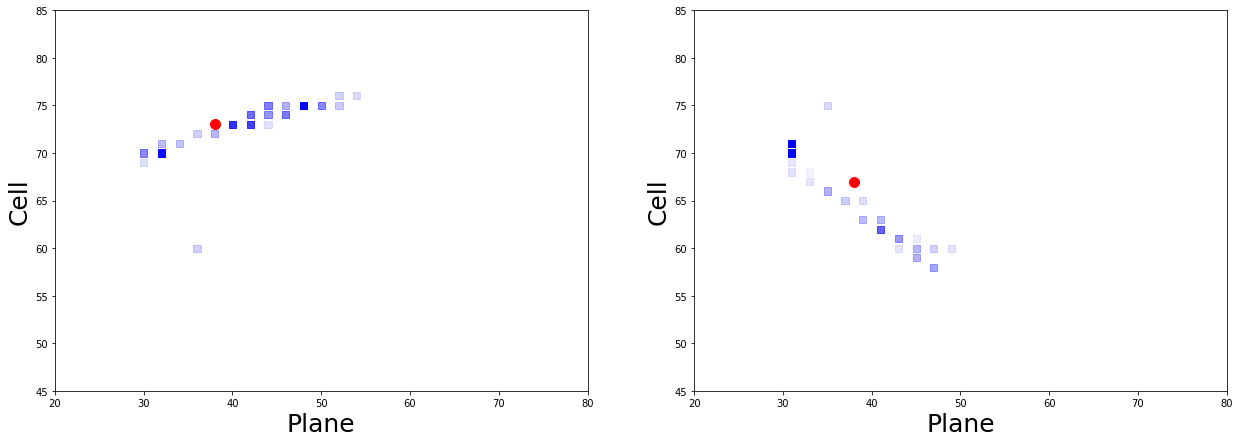

In [36]:
plot_event_with_vtx(x, y, 4)

# Vertex Results

In [39]:
path = "/baldig/physicsprojects/nova/predictions/vertex_flat_l2_0.0_fc_l2_0.0_dropout_0.0_optimizer_adam_lr_0.0005_lrdecay_1e-05_momentum_0.7_batch_size_32_num_layers_3_filter_number_32_20180922-093549_num_train_samples_969903__num_valid_samples_244040__vertex_flat.pkl"
with open(path, 'rb') as f:
    results = pickle.load(f)

In [80]:
len(results['y'])

64000

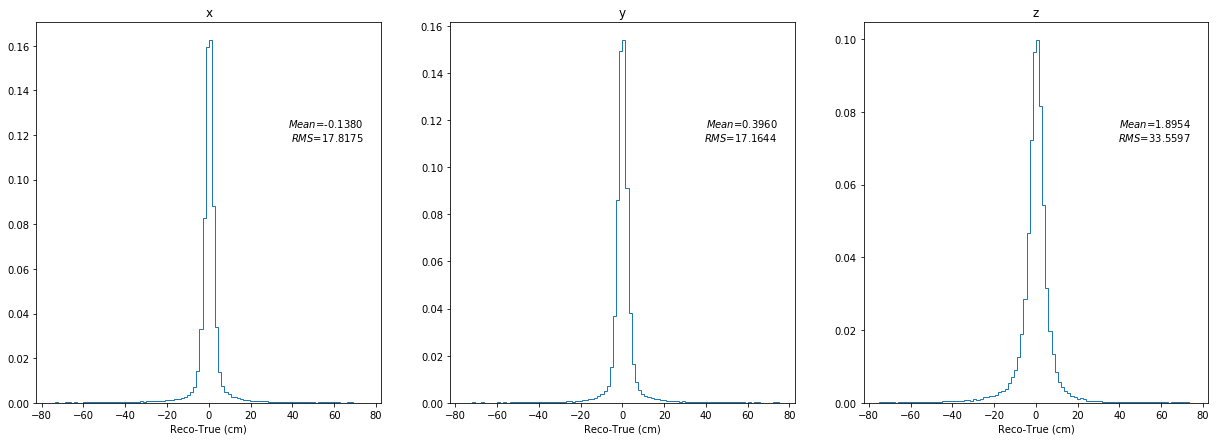

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
ranges = {'x': (-6, 6), 'y': (-6.5, 6.5), 'z': (-9, 9)}

for i, label in enumerate(['x', 'y', 'z']):
    x = results['yhat'][:, i]-results['y'][:, i]
    n, bins, patch = ax[i].hist(x, histtype='step', bins=100, range=(-75, 75), label=label, normed=True)
    mu, sigma = get_curve(x, ranges[label])
#     y = mlab.normpdf(bins, mu, sigma)
#     l = ax[i].plot(bins, y, '--', c='r')
#     l = ax[i].text(right+0.2, top, "$\mu$={0:.4f}\n$\sigma$={1:.4f}".format(mu, sigma),
#             horizontalalignment='right',
#             verticalalignment='top',
#             transform=ax[i].transAxes)
    l = ax[i].text(right+0.2, top, "$Mean$={0:.4f}\n$RMS$={1:.4f}".format(np.mean(x), np.std(x)),
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax[i].transAxes)
    ax[i].set_title(label)
    ax[i].set_xlabel('Reco-True (cm)')

Text(0.5,1,'Vertex')

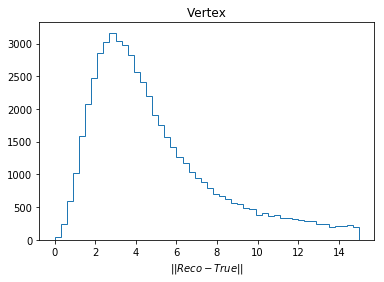

In [57]:
plt.hist(np.sqrt(np.sum((results['yhat']-results['y'])**2, axis=1)), histtype='step', bins=50, range=(0, 15), label='x')
plt.xlabel("$||Reco-True||$")
plt.title("Vertex")

In [72]:
df_path = "/baldig/physicsprojects/nova/data/raw/flat_df"
df0 = pd.read_hdf(os.path.join(df_path, "0.h5"))
df_red0 = df.drop_duplicates(subset=['Run', 'SubRun', 'Event', 'SubEvent', 'Slice'])

In [88]:
df = pd.read_hdf(os.path.join(df_path, "0.h5"))
df_red = df.drop_duplicates(subset=[
    'Run', 'SubRun', 'Event', 'SubEvent', 'Slice']).loc[:, ['SheStart[0]', 'SheStart[1]', 'SheStart[2]',
                                                            'TrueNuVtx[0]', 'TrueNuVtx[1]', 'TrueNuVtx[2]']]

for i in range(1, 20):
    df_new = pd.read_hdf(os.path.join(df_path, "{}.h5").format(i))
    df_red_new = df_new.drop_duplicates(subset=[
        'Run', 'SubRun', 'Event', 'SubEvent', 'Slice']).loc[:, ['SheStart[0]', 'SheStart[1]', 'SheStart[2]',
                                                                'TrueNuVtx[0]', 'TrueNuVtx[1]', 'TrueNuVtx[2]']]
    df_red = df_red.append(df_red_new)

In [89]:
df = df_red

In [90]:
df.keys()

Index(['SheStart[0]', 'SheStart[1]', 'SheStart[2]', 'TrueNuVtx[0]',
       'TrueNuVtx[1]', 'TrueNuVtx[2]'],
      dtype='object')

In [91]:
len(df)

60439

In [157]:
len(results['yhat'])

64000

0.09060915675474462 36.418961387036184
1.6879041022404402 35.70313101895085
23.50706426727775 70.87746197130936


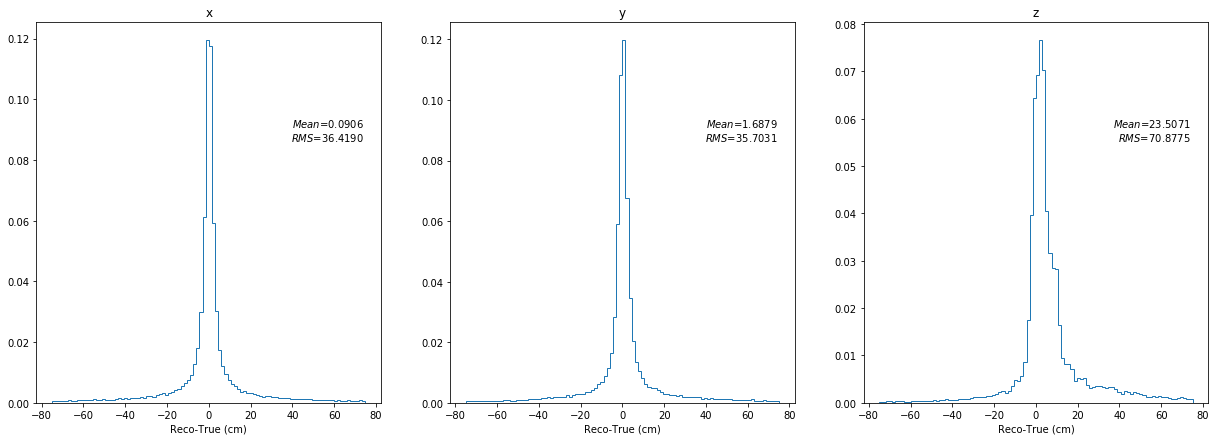

In [127]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))

ranges = {'x': (-6, 6), 'y': (-6.5, 6.5), 'z': (-11, 11)}

for i, label in enumerate(['x', 'y', 'z']):
    x = df.loc[:, 'SheStart[{}]'.format(i)]-df.loc[:, 'TrueNuVtx[{}]'.format(i)]
    n, bins, patch = ax[i].hist(x, histtype='step', bins=100, range=(-75, 75), label=label, normed=True)
    print(np.mean(x), np.std(x))
    mu, sigma = get_curve(x, ranges[label])
    y = mlab.normpdf(bins, mu, sigma)
#     l = ax[i].plot(bins, y, '--', c='r')
#     l = ax[i].text(right+0.2, top, "$\mu$={0:.4f}\n$\sigma$={1:.4f}".format(mu, sigma),
#             horizontalalignment='right',
#             verticalalignment='top',
#             transform=ax[i].transAxes)
    l = ax[i].text(right+0.2, top, "$Mean$={0:.4f}\n$RMS$={1:.4f}".format(np.mean(x), np.std(x)),
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax[i].transAxes)
    ax[i].set_title(label)
    ax[i].set_xlabel('Reco-True (cm)')

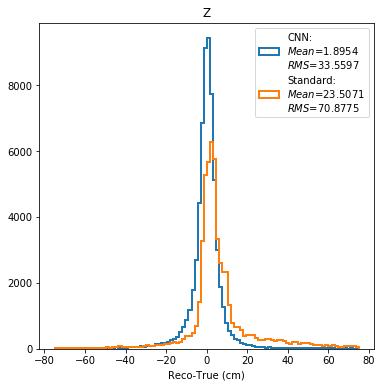

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

label = 'Z'
i = 2
method = 'CNN'
x = results['yhat'][:, i]-results['y'][:, i]
n, bins, patch = ax.hist(x, histtype='step', bins=100, range=(-75, 75), label="{0}:\n$Mean$={1:.4f}\n$RMS$={2:.4f}".format(method, np.mean(x), np.std(x)), normed=True, linewidth=2.)

method = 'Standard'
x = df.loc[:, 'SheStart[{}]'.format(i)]-df.loc[:, 'TrueNuVtx[{}]'.format(i)]
n, bins, patch = ax.hist(x, histtype='step', bins=100, range=(-75, 75), label="{0}:\n$Mean$={1:.4f}\n$RMS$={2:.4f}".format(method, np.mean(x), np.std(x)), normed=True, linewidth=2.)

ax.legend()

ax.set_title(label)
ax.set_xlabel('Reco-True (cm)')
plt.savefig('vertex-{}.pdf'.format(label))
plt.show()

Text(0.5,1,'Traditional Vertex')

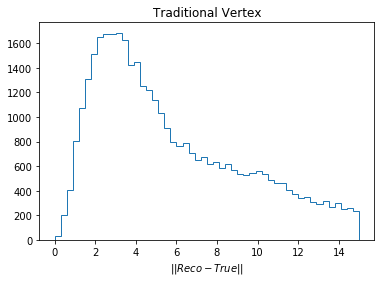

In [95]:
plt.hist(np.sqrt((df.loc[:, 'SheStart[0]']-df.loc[:, 'TrueNuVtx[0]'])**2 + (df.loc[:, 'SheStart[1]']-df.loc[:, 'TrueNuVtx[1]'])**2 + (df.loc[:, 'SheStart[2]']-df.loc[:, 'TrueNuVtx[2]'])**2), histtype='step', bins=50, range=(0, 15), label='x')
plt.xlabel("$||Reco-True||$")
plt.title("Traditional Vertex")

In [148]:
output = """Epoch 1/100
2018-09-22 09:36:06.373930: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-09-22 09:36:07.378457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties:
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:83:00.0
totalMemory: 11.93GiB freeMemory: 11.81GiB
2018-09-22 09:36:07.378516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1120] Creating TensorFlow device (/device:GPU:0) -> (device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2)
Epoch 2/100
7577/7577 [==============================] - 758s 100ms/step - loss: 11.9602 - mean_absolute_error: 11.9602 - mean_squared_error: 729.6420 - val_loss: 12.5658 - val_mean_absolute_error: 12.5658 - val_mean_squared_error: 604.1277
Epoch 3/100
7577/7577 [==============================] - 782s 103ms/step - loss: 10.8078 - mean_absolute_error: 10.8078 - mean_squared_error: 642.5861 - val_loss: 7.9926 - val_mean_absolute_error: 7.9926 - val_mean_squared_error: 644.7221
Epoch 4/100
7577/7577 [==============================] - 1118s 148ms/step - loss: 10.2327 - mean_absolute_error: 10.2327 - mean_squared_error: 681.5214 - val_loss: 8.1943 - val_mean_absolute_error: 8.1943 - val_mean_squared_error: 689.6420
Epoch 5/100
7577/7577 [==============================] - 1080s 142ms/step - loss: 9.9774 - mean_absolute_error: 9.9774 - mean_squared_error: 753.0533 - val_loss: 8.5349 - val_mean_absolute_error: 8.5349 - val_mean_squared_error: 766.8374
Epoch 6/100
7577/7577 [==============================] - 1106s 146ms/step - loss: 9.2018 - mean_absolute_error: 9.2018 - mean_squared_error: 590.0989 - val_loss: 9.4442 - val_mean_absolute_error: 9.4442 - val_mean_squared_error: 596.3576
Epoch 7/100
7577/7577 [==============================] - 1144s 151ms/step - loss: 8.9495 - mean_absolute_error: 8.9495 - mean_squared_error: 604.6422 - val_loss: 9.4060 - val_mean_absolute_error: 9.4060 - val_mean_squared_error: 603.3286
Epoch 8/100
7577/7577 [==============================] - 1110s 146ms/step - loss: 7.2284 - mean_absolute_error: 7.2284 - mean_squared_error: 593.4678 - val_loss: 6.9297 - val_mean_absolute_error: 6.9297 - val_mean_squared_error: 481.6038
Epoch 9/100
7577/7577 [==============================] - 1025s 135ms/step - loss: 6.9157 - mean_absolute_error: 6.9157 - mean_squared_error: 529.3658 - val_loss: 7.2671 - val_mean_absolute_error: 7.2671 - val_mean_squared_error: 615.7705
Epoch 10/100
7577/7577 [==============================] - 1054s 139ms/step - loss: 7.1836 - mean_absolute_error: 7.1836 - mean_squared_error: 606.6410 - val_loss: 7.0738 - val_mean_absolute_error: 7.0738 - val_mean_squared_error: 491.6828
Epoch 11/100
7577/7577 [==============================] - 1074s 142ms/step - loss: 7.1292 - mean_absolute_error: 7.1292 - mean_squared_error: 668.2318 - val_loss: 7.2483 - val_mean_absolute_error: 7.2483 - val_mean_squared_error: 674.3652
Epoch 12/100
7577/7577 [==============================] - 1095s 145ms/step - loss: 6.9605 - mean_absolute_error: 6.9605 - mean_squared_error: 618.1143 - val_loss: 6.4722 - val_mean_absolute_error: 6.4722 - val_mean_squared_error: 537.6554
Epoch 13/100
7577/7577 [==============================] - 1083s 143ms/step - loss: 6.7018 - mean_absolute_error: 6.7018 - mean_squared_error: 614.8261 - val_loss: 6.5623 - val_mean_absolute_error: 6.5623 - val_mean_squared_error: 568.8044
Epoch 14/100
7577/7577 [==============================] - 1124s 148ms/step - loss: 6.4765 - mean_absolute_error: 6.4765 - mean_squared_error: 543.9708 - val_loss: 6.6206 - val_mean_absolute_error: 6.6206 - val_mean_squared_error: 604.4494
Epoch 15/100
7577/7577 [==============================] - 1137s 150ms/step - loss: 6.6183 - mean_absolute_error: 6.6183 - mean_squared_error: 571.8720 - val_loss: 6.6587 - val_mean_absolute_error: 6.6587 - val_mean_squared_error: 508.4483
Epoch 16/100
7577/7577 [==============================] - 1082s 143ms/step - loss: 6.4664 - mean_absolute_error: 6.4664 - mean_squared_error: 527.0581 - val_loss: 6.0885 - val_mean_absolute_error: 6.0885 - val_mean_squared_error: 451.2765
Epoch 17/100
7577/7577 [==============================] - 1026s 135ms/step - loss: 6.3252 - mean_absolute_error: 6.3252 - mean_squared_error: 552.1056 - val_loss: 6.1530 - val_mean_absolute_error: 6.1530 - val_mean_squared_error: 490.5736
Epoch 18/100
7577/7577 [==============================] - 1037s 137ms/step - loss: 6.2506 - mean_absolute_error: 6.2506 - mean_squared_error: 619.5391 - val_loss: 6.0591 - val_mean_absolute_error: 6.0591 - val_mean_squared_error: 458.6559
Epoch 19/100
7577/7577 [==============================] - 1060s 140ms/step - loss: 5.9658 - mean_absolute_error: 5.9658 - mean_squared_error: 481.3072 - val_loss: 6.1386 - val_mean_absolute_error: 6.1386 - val_mean_squared_error: 572.4129
Epoch 20/100
7577/7577 [==============================] - 1044s 138ms/step - loss: 6.0872 - mean_absolute_error: 6.0872 - mean_squared_error: 471.4017 - val_loss: 6.3415 - val_mean_absolute_error: 6.3415 - val_mean_squared_error: 525.3966
Epoch 21/100
7577/7577 [==============================] - 982s 130ms/step - loss: 6.2176 - mean_absolute_error: 6.2176 - mean_squared_error: 563.8591 - val_loss: 6.6528 - val_mean_absolute_error: 6.6528 - val_mean_squared_error: 615.9049
Epoch 22/100
7577/7577 [==============================] - 952s 126ms/step - loss: 6.1213 - mean_absolute_error: 6.1213 - mean_squared_error: 514.5233 - val_loss: 5.9598 - val_mean_absolute_error: 5.9598 - val_mean_squared_error: 510.3608
Epoch 23/100
7577/7577 [==============================] - 965s 127ms/step - loss: 5.9300 - mean_absolute_error: 5.9300 - mean_squared_error: 504.2866 - val_loss: 6.3682 - val_mean_absolute_error: 6.3682 - val_mean_squared_error: 570.6240
Epoch 24/100
7577/7577 [==============================] - 950s 125ms/step - loss: 5.9764 - mean_absolute_error: 5.9764 - mean_squared_error: 487.9466 - val_loss: 5.7267 - val_mean_absolute_error: 5.7267 - val_mean_squared_error: 398.0911
Epoch 25/100
7577/7577 [==============================] - 870s 115ms/step - loss: 5.9165 - mean_absolute_error: 5.9165 - mean_squared_error: 487.6316 - val_loss: 6.2813 - val_mean_absolute_error: 6.2813 - val_mean_squared_error: 573.9799
Epoch 26/100
7577/7577 [==============================] - 899s 119ms/step - loss: 6.2337 - mean_absolute_error: 6.2337 - mean_squared_error: 562.1904 - val_loss: 5.8235 - val_mean_absolute_error: 5.8235 - val_mean_squared_error: 432.3912
Epoch 27/100
7577/7577 [==============================] - 899s 119ms/step - loss: 6.0900 - mean_absolute_error: 6.0900 - mean_squared_error: 502.9692 - val_loss: 6.1286 - val_mean_absolute_error: 6.1286 - val_mean_squared_error: 469.3404
Epoch 28/100
7577/7577 [==============================] - 991s 131ms/step - loss: 6.3474 - mean_absolute_error: 6.3474 - mean_squared_error: 615.6741 - val_loss: 6.1105 - val_mean_absolute_error: 6.1105 - val_mean_squared_error: 503.3691
Epoch 29/100
7577/7577 [==============================] - 995s 131ms/step - loss: 6.0720 - mean_absolute_error: 6.0720 - mean_squared_error: 536.2396 - val_loss: 6.0841 - val_mean_absolute_error: 6.0841 - val_mean_squared_error: 524.5341
Epoch 30/100
7577/7577 [==============================] - 1067s 141ms/step - loss: 6.1765 - mean_absolute_error: 6.1765 - mean_squared_error: 575.6334 - val_loss: 5.9039 - val_mean_absolute_error: 5.9039 - val_mean_squared_error: 430.4947
Epoch 31/100
7577/7577 [==============================] - 1057s 140ms/step - loss: 5.8751 - mean_absolute_error: 5.8751 - mean_squared_error: 429.1343 - val_loss: 6.4723 - val_mean_absolute_error: 6.4723 - val_mean_squared_error: 610.5463
Epoch 32/100
7577/7577 [==============================] - 1036s 137ms/step - loss: 5.9801 - mean_absolute_error: 5.9801 - mean_squared_error: 509.4406 - val_loss: 5.9906 - val_mean_absolute_error: 5.9906 - val_mean_squared_error: 474.5944
Epoch 33/100
7577/7577 [==============================] - 1021s 135ms/step - loss: 5.9017 - mean_absolute_error: 5.9017 - mean_squared_error: 469.5577 - val_loss: 6.1052 - val_mean_absolute_error: 6.1052 - val_mean_squared_error: 525.8278
Epoch 34/100
7577/7577 [==============================] - 1071s 141ms/step - loss: 6.2252 - mean_absolute_error: 6.2252 - mean_squared_error: 613.3468 - val_loss: 6.4915 - val_mean_absolute_error: 6.4915 - val_mean_squared_error: 642.1744
Epoch 35/100
7577/7577 [==============================] - 1083s 143ms/step - loss: 6.1346 - mean_absolute_error: 6.1346 - mean_squared_error: 505.5739 - val_loss: 5.7089 - val_mean_absolute_error: 5.7089 - val_mean_squared_error: 392.4190
Epoch 36/100
7577/7577 [==============================] - 1058s 140ms/step - loss: 5.9872 - mean_absolute_error: 5.9872 - mean_squared_error: 479.1877 - val_loss: 5.9997 - val_mean_absolute_error: 5.9997 - val_mean_squared_error: 447.2496
Epoch 37/100
7577/7577 [==============================] - 1065s 141ms/step - loss: 6.1441 - mean_absolute_error: 6.1441 - mean_squared_error: 525.7827 - val_loss: 6.3936 - val_mean_absolute_error: 6.3936 - val_mean_squared_error: 615.1861
Epoch 38/100
7577/7577 [==============================] - 1054s 139ms/step - loss: 5.9462 - mean_absolute_error: 5.9462 - mean_squared_error: 484.2006 - val_loss: 5.6888 - val_mean_absolute_error: 5.6888 - val_mean_squared_error: 413.8496
Epoch 39/100
7577/7577 [==============================] - 1093s 144ms/step - loss: 5.9108 - mean_absolute_error: 5.9108 - mean_squared_error: 488.2753 - val_loss: 6.1361 - val_mean_absolute_error: 6.1361 - val_mean_squared_error: 479.0783
Epoch 40/100
7577/7577 [==============================] - 1080s 143ms/step - loss: 6.2283 - mean_absolute_error: 6.2283 - mean_squared_error: 607.3944 - val_loss: 6.2416 - val_mean_absolute_error: 6.2416 - val_mean_squared_error: 592.8787
Epoch 41/100
7577/7577 [==============================] - 1025s 135ms/step - loss: 6.3191 - mean_absolute_error: 6.3191 - mean_squared_error: 591.4866 - val_loss: 5.8153 - val_mean_absolute_error: 5.8153 - val_mean_squared_error: 443.0339
Epoch 42/100
7577/7577 [==============================] - 1072s 142ms/step - loss: 6.0149 - mean_absolute_error: 6.0149 - mean_squared_error: 490.3026 - val_loss: 6.5414 - val_mean_absolute_error: 6.5414 - val_mean_squared_error: 588.7234
Epoch 43/100
7577/7577 [==============================] - 1079s 142ms/step - loss: 6.1051 - mean_absolute_error: 6.1051 - mean_squared_error: 545.7669 - val_loss: 6.0535 - val_mean_absolute_error: 6.0535 - val_mean_squared_error: 489.6757
Epoch 44/100
7577/7577 [==============================] - 988s 130ms/step - loss: 5.9296 - mean_absolute_error: 5.9296 - mean_squared_error: 514.3556 - val_loss: 5.7322 - val_mean_absolute_error: 5.7322 - val_mean_squared_error: 391.1151
Epoch 45/100
7577/7577 [==============================] - 944s 125ms/step - loss: 5.8698 - mean_absolute_error: 5.8698 - mean_squared_error: 491.5628 - val_loss: 6.3567 - val_mean_absolute_error: 6.3567 - val_mean_squared_error: 624.4870
Epoch 46/100
7577/7577 [==============================] - 952s 126ms/step - loss: 6.0781 - mean_absolute_error: 6.0781 - mean_squared_error: 515.1927 - val_loss: 6.0354 - val_mean_absolute_error: 6.0354 - val_mean_squared_error: 464.9057
Epoch 47/100
7577/7577 [==============================] - 970s 128ms/step - loss: 6.0677 - mean_absolute_error: 6.0677 - mean_squared_error: 518.3041 - val_loss: 6.2522 - val_mean_absolute_error: 6.2522 - val_mean_squared_error: 550.6756
Epoch 48/100
7577/7577 [==============================] - 922s 122ms/step - loss: 6.0985 - mean_absolute_error: 6.0985 - mean_squared_error: 524.7462 - val_loss: 5.6049 - val_mean_absolute_error: 5.6049 - val_mean_squared_error: 355.4827
Epoch 49/100
7577/7577 [==============================] - 841s 111ms/step - loss: 5.9352 - mean_absolute_error: 5.9352 - mean_squared_error: 491.0745 - val_loss: 6.4091 - val_mean_absolute_error: 6.4091 - val_mean_squared_error: 583.1283
Epoch 50/100
7577/7577 [==============================] - 865s 114ms/step - loss: 5.9541 - mean_absolute_error: 5.9541 - mean_squared_error: 463.1742 - val_loss: 5.5093 - val_mean_absolute_error: 5.5093 - val_mean_squared_error: 343.8408
Epoch 51/100
7577/7577 [==============================] - 899s 119ms/step - loss: 6.0913 - mean_absolute_error: 6.0913 - mean_squared_error: 551.2900 - val_loss: 6.4531 - val_mean_absolute_error: 6.4531 - val_mean_squared_error: 642.6177
Epoch 52/100
7577/7577 [==============================] - 924s 122ms/step - loss: 6.1323 - mean_absolute_error: 6.1323 - mean_squared_error: 592.5378 - val_loss: 6.2063 - val_mean_absolute_error: 6.2063 - val_mean_squared_error: 544.7081
Epoch 53/100
7577/7577 [==============================] - 1056s 139ms/step - loss: 6.1864 - mean_absolute_error: 6.1864 - mean_squared_error: 537.6238 - val_loss: 5.9485 - val_mean_absolute_error: 5.9485 - val_mean_squared_error: 553.2732
Epoch 54/100
7577/7577 [==============================] - 1293s 171ms/step - loss: 6.0403 - mean_absolute_error: 6.0403 - mean_squared_error: 494.6592 - val_loss: 5.7220 - val_mean_absolute_error: 5.7220 - val_mean_squared_error: 390.1623
Epoch 55/100
7577/7577 [==============================] - 1287s 170ms/step - loss: 5.9136 - mean_absolute_error: 5.9136 - mean_squared_error: 492.7865 - val_loss: 6.4106 - val_mean_absolute_error: 6.4106 - val_mean_squared_error: 553.4597
Epoch 56/100
7577/7577 [==============================] - 1058s 140ms/step - loss: 6.0125 - mean_absolute_error: 6.0125 - mean_squared_error: 503.1673 - val_loss: 6.2915 - val_mean_absolute_error: 6.2915 - val_mean_squared_error: 540.4834
Epoch 57/100
7577/7577 [==============================] - 1034s 136ms/step - loss: 5.9686 - mean_absolute_error: 5.9686 - mean_squared_error: 456.7331 - val_loss: 6.0550 - val_mean_absolute_error: 6.0550 - val_mean_squared_error: 489.6499
Epoch 58/100
7577/7577 [==============================] - 1070s 141ms/step - loss: 6.1373 - mean_absolute_error: 6.1373 - mean_squared_error: 582.9136 - val_loss: 5.8982 - val_mean_absolute_error: 5.8982 - val_mean_squared_error: 422.4065
Epoch 59/100
7577/7577 [==============================] - 1073s 142ms/step - loss: 5.9125 - mean_absolute_error: 5.9125 - mean_squared_error: 525.6253 - val_loss: 5.8325 - val_mean_absolute_error: 5.8325 - val_mean_squared_error: 513.2489
Epoch 60/100
7577/7577 [==============================] - 1088s 144ms/step - loss: 6.0875 - mean_absolute_error: 6.0875 - mean_squared_error: 508.7498 - val_loss: 6.2098 - val_mean_absolute_error: 6.2098 - val_mean_squared_error: 515.2459
Epoch 61/100
7577/7577 [==============================] - 1099s 145ms/step - loss: 6.0533 - mean_absolute_error: 6.0533 - mean_squared_error: 501.1199 - val_loss: 6.5110 - val_mean_absolute_error: 6.5110 - val_mean_squared_error: 611.0129
Epoch 62/100
7577/7577 [==============================] - 1106s 146ms/step - loss: 6.0152 - mean_absolute_error: 6.0152 - mean_squared_error: 542.1241 - val_loss: 6.2694 - val_mean_absolute_error: 6.2694 - val_mean_squared_error: 520.7494
Epoch 63/100
7577/7577 [==============================] - 1086s 143ms/step - loss: 6.0534 - mean_absolute_error: 6.0534 - mean_squared_error: 550.1513 - val_loss: 5.7073 - val_mean_absolute_error: 5.7073 - val_mean_squared_error: 376.6807
Epoch 64/100
7577/7577 [==============================] - 1072s 141ms/step - loss: 5.9200 - mean_absolute_error: 5.9200 - mean_squared_error: 495.8732 - val_loss: 5.7631 - val_mean_absolute_error: 5.7631 - val_mean_squared_error: 509.4180
Epoch 65/100
7577/7577 [==============================] - 1067s 141ms/step - loss: 5.9367 - mean_absolute_error: 5.9367 - mean_squared_error: 502.8941 - val_loss: 6.3218 - val_mean_absolute_error: 6.3218 - val_mean_squared_error: 524.3048
Epoch 66/100
7577/7577 [==============================] - 1086s 143ms/step - loss: 6.0719 - mean_absolute_error: 6.0719 - mean_squared_error: 520.1458 - val_loss: 5.8955 - val_mean_absolute_error: 5.8955 - val_mean_squared_error: 489.9450
Epoch 67/100
7577/7577 [==============================] - 1083s 143ms/step - loss: 6.0460 - mean_absolute_error: 6.0460 - mean_squared_error: 557.8858 - val_loss: 5.9636 - val_mean_absolute_error: 5.9636 - val_mean_squared_error: 476.6285
Epoch 68/100
7577/7577 [==============================] - 1036s 137ms/step - loss: 5.9832 - mean_absolute_error: 5.9832 - mean_squared_error: 488.0863 - val_loss: 6.1021 - val_mean_absolute_error: 6.1021 - val_mean_squared_error: 528.1612
Epoch 69/100
7577/7577 [==============================] - 1003s 132ms/step - loss: 6.1745 - mean_absolute_error: 6.1745 - mean_squared_error: 586.2414 - val_loss: 5.7672 - val_mean_absolute_error: 5.7672 - val_mean_squared_error: 398.2203
Epoch 70/100
7577/7577 [==============================] - 1015s 134ms/step - loss: 5.9705 - mean_absolute_error: 5.9705 - mean_squared_error: 501.3773 - val_loss: 5.6516 - val_mean_absolute_error: 5.6516 - val_mean_squared_error: 435.9407
Epoch 71/100
7577/7577 [==============================] - 1027s 136ms/step - loss: 5.9356 - mean_absolute_error: 5.9356 - mean_squared_error: 472.5432 - val_loss: 5.7509 - val_mean_absolute_error: 5.7509 - val_mean_squared_error: 447.9719
Epoch 72/100
7577/7577 [==============================] - 987s 130ms/step - loss: 6.0575 - mean_absolute_error: 6.0575 - mean_squared_error: 590.9948 - val_loss: 6.7081 - val_mean_absolute_error: 6.7081 - val_mean_squared_error: 648.2008
Epoch 73/100
7577/7577 [==============================] - 943s 124ms/step - loss: 5.8935 - mean_absolute_error: 5.8935 - mean_squared_error: 477.1578 - val_loss: 5.5597 - val_mean_absolute_error: 5.5597 - val_mean_squared_error: 429.7698
Epoch 74/100
7577/7577 [==============================] - 1018s 134ms/step - loss: 5.9542 - mean_absolute_error: 5.9542 - mean_squared_error: 486.1961 - val_loss: 6.2059 - val_mean_absolute_error: 6.2059 - val_mean_squared_error: 517.4510
Epoch 75/100
7577/7577 [==============================] - 992s 131ms/step - loss: 6.0186 - mean_absolute_error: 6.0186 - mean_squared_error: 465.7639 - val_loss: 6.4257 - val_mean_absolute_error: 6.4257 - val_mean_squared_error: 585.0515
Epoch 76/100
7577/7577 [==============================] - 1005s 133ms/step - loss: 6.0857 - mean_absolute_error: 6.0857 - mean_squared_error: 563.1655 - val_loss: 6.1311 - val_mean_absolute_error: 6.1311 - val_mean_squared_error: 564.7573
Epoch 77/100
7577/7577 [==============================] - 1011s 133ms/step - loss: 5.8865 - mean_absolute_error: 5.8865 - mean_squared_error: 445.4096 - val_loss: 6.3007 - val_mean_absolute_error: 6.3007 - val_mean_squared_error: 576.4368
Epoch 78/100
7577/7577 [==============================] - 1092s 144ms/step - loss: 6.0814 - mean_absolute_error: 6.0814 - mean_squared_error: 529.9818 - val_loss: 5.7839 - val_mean_absolute_error: 5.7839 - val_mean_squared_error: 415.7466
Epoch 79/100
7577/7577 [==============================] - 1083s 143ms/step - loss: 5.7683 - mean_absolute_error: 5.7683 - mean_squared_error: 504.8980 - val_loss: 5.7040 - val_mean_absolute_error: 5.7040 - val_mean_squared_error: 396.4735
Epoch 80/100
7577/7577 [==============================] - 1052s 139ms/step - loss: 6.2110 - mean_absolute_error: 6.2110 - mean_squared_error: 548.5734 - val_loss: 6.1450 - val_mean_absolute_error: 6.1450 - val_mean_squared_error: 506.0178
Epoch 81/100
7577/7577 [==============================] - 1068s 141ms/step - loss: 6.0579 - mean_absolute_error: 6.0579 - mean_squared_error: 530.3543 - val_loss: 5.9117 - val_mean_absolute_error: 5.9117 - val_mean_squared_error: 420.3661
Epoch 82/100
7577/7577 [==============================] - 1065s 141ms/step - loss: 5.8369 - mean_absolute_error: 5.8369 - mean_squared_error: 495.7389 - val_loss: 5.4572 - val_mean_absolute_error: 5.4572 - val_mean_squared_error: 370.3036
Epoch 83/100
7577/7577 [==============================] - 1092s 144ms/step - loss: 6.1522 - mean_absolute_error: 6.1522 - mean_squared_error: 591.8196 - val_loss: 6.8778 - val_mean_absolute_error: 6.8778 - val_mean_squared_error: 760.9451
Epoch 84/100
7577/7577 [==============================] - 1027s 136ms/step - loss: 5.9434 - mean_absolute_error: 5.9434 - mean_squared_error: 487.6197 - val_loss: 6.0096 - val_mean_absolute_error: 6.0096 - val_mean_squared_error: 554.1679
Epoch 85/100
7577/7577 [==============================] - 1030s 136ms/step - loss: 5.8700 - mean_absolute_error: 5.8700 - mean_squared_error: 478.1620 - val_loss: 5.8597 - val_mean_absolute_error: 5.8597 - val_mean_squared_error: 445.7758
Epoch 86/100
7577/7577 [==============================] - 1082s 143ms/step - loss: 6.0536 - mean_absolute_error: 6.0536 - mean_squared_error: 503.4426 - val_loss: 6.3852 - val_mean_absolute_error: 6.3852 - val_mean_squared_error: 539.2045
Epoch 87/100
7577/7577 [==============================] - 1090s 144ms/step - loss: 5.9695 - mean_absolute_error: 5.9695 - mean_squared_error: 557.7134 - val_loss: 5.6298 - val_mean_absolute_error: 5.6298 - val_mean_squared_error: 440.4062
Epoch 88/100
7577/7577 [==============================] - 1037s 137ms/step - loss: 5.9171 - mean_absolute_error: 5.9171 - mean_squared_error: 489.0480 - val_loss: 5.8573 - val_mean_absolute_error: 5.8573 - val_mean_squared_error: 518.2056
Epoch 89/100
7577/7577 [==============================] - 1056s 139ms/step - loss: 6.1305 - mean_absolute_error: 6.1305 - mean_squared_error: 563.6284 - val_loss: 6.0997 - val_mean_absolute_error: 6.0997 - val_mean_squared_error: 508.9473
Epoch 90/100
7577/7577 [==============================] - 1054s 139ms/step - loss: 5.9256 - mean_absolute_error: 5.9256 - mean_squared_error: 493.8169 - val_loss: 6.1752 - val_mean_absolute_error: 6.1752 - val_mean_squared_error: 492.2937
Epoch 91/100
7577/7577 [==============================] - 1061s 140ms/step - loss: 5.9825 - mean_absolute_error: 5.9825 - mean_squared_error: 533.9880 - val_loss: 5.5885 - val_mean_absolute_error: 5.5885 - val_mean_squared_error: 358.6757
Epoch 92/100
7577/7577 [==============================] - 967s 128ms/step - loss: 6.0631 - mean_absolute_error: 6.0631 - mean_squared_error: 529.9440 - val_loss: 6.3129 - val_mean_absolute_error: 6.3129 - val_mean_squared_error: 574.0949
Epoch 93/100
7577/7577 [==============================] - 972s 128ms/step - loss: 5.9680 - mean_absolute_error: 5.9680 - mean_squared_error: 527.2337 - val_loss: 5.9290 - val_mean_absolute_error: 5.9290 - val_mean_squared_error: 552.0904
Epoch 94/100
7577/7577 [==============================] - 930s 123ms/step - loss: 5.9154 - mean_absolute_error: 5.9154 - mean_squared_error: 472.1204 - val_loss: 5.9610 - val_mean_absolute_error: 5.9610 - val_mean_squared_error: 447.1164
Epoch 95/100
7577/7577 [==============================] - 935s 123ms/step - loss: 5.9191 - mean_absolute_error: 5.9191 - mean_squared_error: 514.3884 - val_loss: 5.8579 - val_mean_absolute_error: 5.8579 - val_mean_squared_error: 449.1880
Epoch 96/100
7577/7577 [==============================] - 884s 117ms/step - loss: 5.8457 - mean_absolute_error: 5.8457 - mean_squared_error: 507.1017 - val_loss: 6.1664 - val_mean_absolute_error: 6.1664 - val_mean_squared_error: 533.9762
Epoch 97/100
7577/7577 [==============================] - 903s 119ms/step - loss: 6.1110 - mean_absolute_error: 6.1110 - mean_squared_error: 523.1873 - val_loss: 6.6222 - val_mean_absolute_error: 6.6222 - val_mean_squared_error: 629.1028
Epoch 98/100
7577/7577 [==============================] - 935s 123ms/step - loss: 5.6436 - mean_absolute_error: 5.6436 - mean_squared_error: 408.0332 - val_loss: 5.6890 - val_mean_absolute_error: 5.6890 - val_mean_squared_error: 458.6199
Epoch 99/100
7577/7577 [==============================] - 1062s 140ms/step - loss: 6.0440 - mean_absolute_error: 6.0440 - mean_squared_error: 521.6933 - val_loss: 5.4541 - val_mean_absolute_error: 5.4541 - val_mean_squared_error: 357.3290
Epoch 100/100
7577/7577 [==============================] - 996s 131ms/step - loss: 6.0453 - mean_absolute_error: 6.0453 - mean_squared_error: 629.4438 - val_loss: 6.2089 - val_mean_absolute_error: 6.2089 - val_mean_squared_error: 521.0186"""

In [146]:
import re

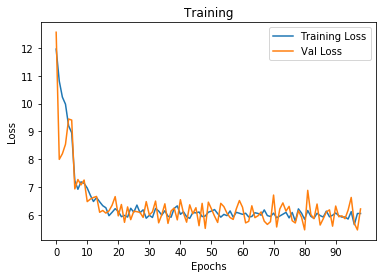

In [154]:
loss = [float(x) for x in re.findall(r" loss: ([0-9]*[.][0-9]*) ", output)]
val_loss = [float(x) for x in re.findall(r"val_loss: ([0-9]*[.][0-9]*)", output)]
plt.plot(list(range(len(loss))), loss, label='Training Loss')
plt.plot(list(range(len(val_loss))), val_loss, label='Val Loss')
plt.xticks(list(range(0, len(loss), 10)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training")
plt.savefig("vertex-loss-curve.pdf")